#### Conditional Tb on the CAPE-SUBSAT diagram

In [1]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [11]:
%%time
# get 1-D results from merged data
data_dir = Path('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/2001/environment_catalogs/VARS_2D')
data_tb = xr.open_dataset(data_dir / 'MCS_FLEXTRKR_tropics_tb.merged.nc')
data_mask = xr.open_dataset(data_dir / 'MCS_FLEXTRKR_tropics_cloudtracknumber_nomergesplit.merged.nc')

bins_tb = np.linspace(190,280,31)
samples_tb = np.zeros((6,len(bins_tb)-1))

for track in data_tb.tracks.values:
    data_sub = data_tb.sel(tracks=track)
    for phase in data_sub.time.values:
        data_phase = data_sub.tb.isel(time=phase)
        cldmask = data_mask.cloudtracknumber_nomergesplit.sel(tracks=track).isel(time=phase)
        data_mcs_phase = data_phase.where(cldmask > 0)

        tb_1d_mcs = data_mcs_phase.values.ravel()
        (samples, bins_edege) = np.histogram(tb_1d_mcs, bins=bins_tb)
        samples_tb[phase,:] += samples

CPU times: user 1min 17s, sys: 177 ms, total: 1min 17s
Wall time: 1min 18s


(190.0, 240.0)

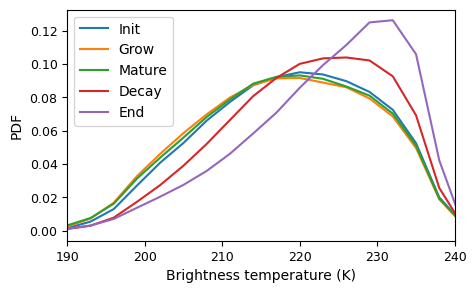

In [14]:
fig = plt.figure(figsize=(5,3))
for n,mcs_phase in zip(range(1,6), ['Init','Grow','Mature','Decay','End']):
    plt.plot(bins_tb[:-1], samples_tb[n,:]/np.sum(samples_tb[n,:]), label=mcs_phase)
plt.legend()
plt.ylabel('PDF',fontsize=10)
plt.xlabel('Brightness temperature (K)',fontsize=10)
plt.tick_params(labelsize=9)
plt.xlim([190,240])

In [3]:
%%time

stats_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')
year_list = np.arange(2001,2021)

for n,year in enumerate(year_list):
        
    data = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.Tb.FNL.alltracks.nc'.format(year))
    if n == 0:
        samples_all_oce = data.samples
        tb_sum_oce = data.tb_sum
    else:
        samples_all_oce = samples_all_oce + data.samples
        tb_sum_oce = tb_sum_oce + data.tb_sum

CPU times: user 9.32 s, sys: 6.95 s, total: 16.3 s
Wall time: 2.69 s


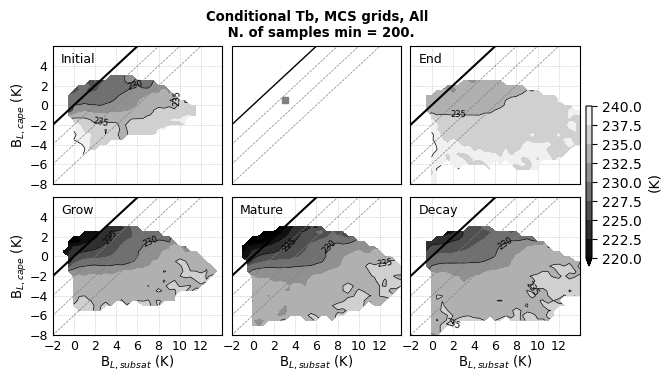

In [26]:
#### contribution of total rainfall 

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

bins_cape = tb_sum_oce.bins_cape
bins_subsat = tb_sum_oce.bins_subsat

dbl = 0.25
tb_sum = tb_sum_oce.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))
samples_all = samples_all_oce.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

# total samples and rain rate in all phases
samples_allphases = samples_all_oce.sel(area_type='mcs',phase=['Initial','End','Grow','Mature','Decay']).sum(('duration_type','phase'))
total_tb = tb_sum.sel(area_type='mcs',phase=['Initial','End','Grow','Mature','Decay']).sum(('duration_type','phase'))

for p,(ax,phase,label_str) in enumerate(zip([ax1,ax3,ax4,ax5,ax6],['Initial','End','Grow','Mature','Decay'],
                                            ['(a)','(b)','(c)','(d)','(e)'])):
    
    var_sum = tb_sum_oce.sel(area_type='mcs', phase=phase).sum('duration_type')
    tmp = samples_all_oce.sel(area_type='mcs', phase=phase).sum('duration_type')
    tmp = tmp.where(tmp > 200)
    
    # conditional mean of gpm precip (mm/hr)
    cp = ax.contourf(tmp.bins_subsat, tmp.bins_cape, var_sum/tmp, cmap='binary_r',
                     levels=np.arange(220,242.5,2.5),zorder=2, extend='min')
    cs = ax.contour(tmp.bins_subsat, tmp.bins_cape, var_sum/tmp, colors='k',linewidths=0.5,
                     levels=[220,225,230,235,240],zorder=2)
    ax.clabel(cs, inline=False, fontsize=6)

    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7)
        cbar.set_label('(K)') 
        
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
    
    ## configuration of tick, labels
    ax.text(-1.2,4.3,'{}'.format(phase),fontsize=9,color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-8,6])
    ax.set_xlim([-2,14])  
    
ax2.tick_params('both', length=0, width=1, which='major')
    
ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
ax2.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)

(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
ax2.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')

ax2.set_ylim([-8,6])
ax2.set_xlim([-2,14])

plt.suptitle('Conditional Tb, MCS grids, All \n N. of samples min = 200.', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.4,w_pad=0.01)

plt.show()

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/BL2Dhist_CondPrec_allsurface.rotate.pdf',
#    bbox_inches='tight',transparent=False)